<a href="https://colab.research.google.com/github/KimDongChan0908/Artificial-Intelligence-Programming/blob/Week---6---Class/Noise_2_ANN_Celsius_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install --quiet torchviz

  Preparing metadata (setup.py) ... done


In [3]:
pip install torchsummary

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchviz
import torchsummary

for c in [np, torch]:
    print(c.__name__, c.__version__)

numpy 1.25.2
torch 2.2.1+cu121


In [5]:
from torch.nn import Module, init, Linear, Parameter, ReLU
from torch import optim

In [22]:
def gen_xy(cnt, std =2.):

    x = np.linspace(-10, 10, cnt)
    y_ideal = 1.8 * x + 32.
    y = y_ideal + std * np.random.randn((cnt))

    x = torch.tensor(x).float().reshape(-1,1)
    y = torch.tensor(y).float().reshape(-1,1)
    y_ideal = torch.tensor(y_ideal).float().reshape(-1,1)

    return x,y,y_ideal

torch.Size([20, 1]) torch.Size([20, 1]) torch.Size([20, 1])


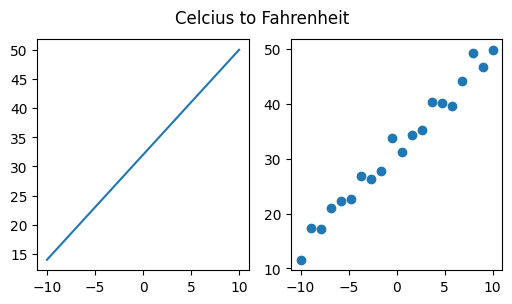

In [23]:
sample_cnt = 20

x, y, y_ideal = gen_xy(sample_cnt)

fig,axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(x.detach(), y_ideal.detach())
axes[1].scatter(x.detach(), y.detach())
fig.suptitle('Celcius to Fahrenheit')
print(x.shape, y.shape, y_ideal.shape)

In [24]:
class DsANN(Module):

    def __init__(self,
                 n_in_f,
                 n_out_f,
                 ):
        super().__init__()

        self.linear0 = Linear(n_in_f, 32)
        self.relu0 = ReLU()

        self.linear1 = Linear(32,32)
        self.relu1 = ReLU()

        self.linear2 = Linear(32, n_out_f)

        with torch.no_grad():
            init.constant_(self.linear0.bias, 0.)
            init.xavier_uniform_(self.linear0.weight)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu0(x)
        x = self.linear1(x)
        x = self.relu1(x)
        y = self.linear2(x)

        return y


In [25]:
model = DsANN(1,1)

for idx,c in enumerate(model.parameters()):
    print(idx, c.shape)

0 torch.Size([32, 1])
1 torch.Size([32])
2 torch.Size([32, 32])
3 torch.Size([32])
4 torch.Size([1, 32])
5 torch.Size([1])


In [26]:
for idx, cl in enumerate(model.children()):
    print(idx, cl)

0 Linear(in_features=1, out_features=32, bias=True)
1 ReLU()
2 Linear(in_features=32, out_features=32, bias=True)
3 ReLU()
4 Linear(in_features=32, out_features=1, bias=True)


In [27]:
for idx, modu in enumerate(model.modules()):
    print(idx, modu)

0 DsANN(
  (linear0): Linear(in_features=1, out_features=32, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)
1 Linear(in_features=1, out_features=32, bias=True)
2 ReLU()
3 Linear(in_features=32, out_features=32, bias=True)
4 ReLU()
5 Linear(in_features=32, out_features=1, bias=True)


In [28]:
from torchsummary import summary

summary(model, (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              64
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [29]:
from torch.nn import MSELoss

pred = model(x)

loss_fnc = MSELoss()
l = loss_fnc(pred, y)
l


tensor(1143.1707, grad_fn=<MseLossBackward0>)

In [30]:
def training_loop(
        x,y,
        model,
        lr,
        n_epochs
):

    model.train()
    optimizer = optim.SGD(
        model.parameters(),
        lr = lr ,)


    for epoch in range(n_epochs):
        pred = model(x)
        l = loss_fnc(pred, y)
        if torch.isinf(l).any():
            print("Error : diverge!")
            break

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch} : Loss : {float(l):0.4f}')
    return model

In [31]:
model = training_loop(
    x,y,
    model,
    1e-3,
    7000
)

Epoch 0 : Loss : 1143.1707
Epoch 1000 : Loss : 3.6185
Epoch 2000 : Loss : 2.5166
Epoch 3000 : Loss : 2.4911
Epoch 4000 : Loss : 2.4704
Epoch 5000 : Loss : 2.5312
Epoch 6000 : Loss : 2.4838


Text(0.5, 0.98, 'celsius to fahrenheit')

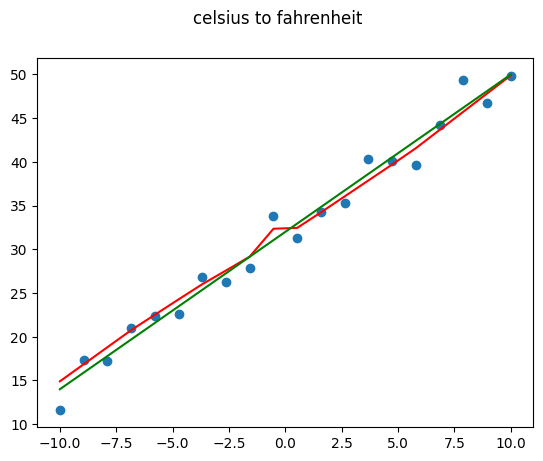

In [36]:
pred = model(x)


fig, axes = plt.subplots(1,1)
axes.scatter(x.detach().numpy(),y.detach().numpy())
axes.plot(x.detach().numpy(),pred.detach().numpy(), color='r')
axes.plot(x.detach().numpy(),y_ideal, color='g')
fig.suptitle('celsius to fahrenheit')

